In [1]:
import river
from river.ensemble import AdaptiveRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")

The River docs are available at https://riverml.xyz/latest/. Note that as of 12/1 they are highly incomplete.

The LED data stream is an incredibly difficult dataset composed of 24 binary features, only 7 of which are relevant. The dependent variable is a digit.
The LEDDrift stream incorporates drift into the LED stream.
The `noise_percentage` parameter indicates that with probability 0.28 a bit will be flipped.

The creation of the static training instances is necessary for Scikit-Learn as discussed below.

In [2]:
train = river.synth.LED(seed=1, noise_percentage=0.28,
                        irrelevant_features=True) 
test = river.synth.LEDDrift(seed=2, noise_percentage=0.28,
                            irrelevant_features=True,
                            n_drift_features=6) 

static = np.array([[*x.values(), y] for x, y in train.take(10_000)])
stat_X, stat_y = static[:, :-1], static[:, -1]

The ensemble size of 100 and `max_depth` of 4 were selected via a grid search using 5-fold cross-validation for the random forest. This is not shown as it is beyond the scope of the talk. Unfortunately, River has undeveloped model selection capabilities, and so it is inferred that the adaptive random forest will have similar hyperparamter optima; that is, we did not perform a grid search or cross validation for the online algorithm.

In [3]:
off = RandomForestClassifier(max_depth=4)
on = AdaptiveRandomForestClassifier(n_models=100, max_depth=4)

Since River is oriented towards element-wise incremental learning, the River API is built around data in dictionaries. Scikit on the other hand is built on NumPy arrays. As such, it was necessary to alter data formats to accord with the APIs. The `train` instance repeatedly outputs LED data samples, then the `learn_one` method increments the `on` model; that is, it performs element-wise online learning. There is also a `learn_many` method for batch-wise incrementation, where appropriate.

In [4]:
off.fit(stat_X, stat_y)

for x, y in train.take(10_000):
    on.learn_one(x, y)

For model evaluation, the `perdict_one` method works analogously to `learn_one`, but of course returns a prediction. There is also a `predict_proba_one`, which of course, returns predicted class probabilities. 

In [5]:
Y_hat = np.zeros([3, 5000])

i = 0
for x, y in test.take(5000):
    Y_hat[0, i] = y
    Y_hat[1, i] = on.predict_one(x)
    Y_hat[2, i] = off.predict([[*x.values()]])
    on.learn_one(x, y)
    i += 1

In [8]:
accs = (pd.DataFrame({'online': Y_hat[0,:] == Y_hat[1,:],
                      'offline': Y_hat[0,:] == Y_hat[2,:]})
        .rolling(window=100)
        .mean()
        .iloc[100:]
        .melt(value_vars=['online', 'offline'], var_name='model',
              value_name='accuracy'))

Comparing the accuracy of the two models, there is a clear winner: ONLINE LEARNING.

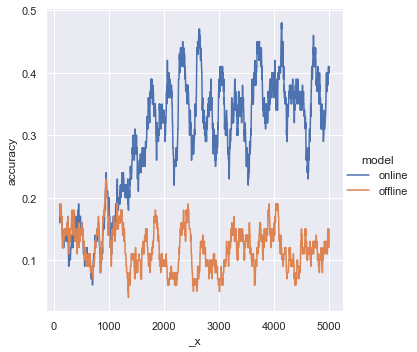

In [9]:
%matplotlib inline
sns.relplot(x=[*range(100, 5000)]*2, y='accuracy', hue='model', kind='line', data=accs)